In [75]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

### Tokenize the text

In [61]:
class Tokenizer:
    def __init__(self):
        self.dictionary = {}
        self.reverse_dictionary = {}

        # Add padding token
        self.__add_to_dict('<pad>')

        # Add characters and numbers to dictionary
        for i in range(10):
            self.__add_to_dict(str(i))
        for i in range(26):
            self.__add_to_dict(chr(ord('a') + i))
        
        # Add space and punctuation to dictionary
        self.__add_to_dict('.')
        self.__add_to_dict(' ')

    def __add_to_dict(self, character):
        if character not in self.dictionary:
            self.dictionary[character] = len(self.dictionary)
            self.reverse_dictionary[self.dictionary[character]] = character
    
    def tokenize(self, text):
        return [self.dictionary[c] for c in text]
    
    def character_to_token(self, character):
        return self.dictionary[character]
    
    def token_to_character(self, token):
        return self.reverse_dictionary[token]
    
    def size(self):
        return len(self.dictionary)

### Dataset

In [62]:
# Create training data
training_data = '. '.join([
    'cats rule the world',
    'dogs are the best',
    'elephants have long trunks',
    'monkeys like bananas',
    'pandas eat bamboo',
    'tigers are dangerous',
    'zebras have stripes',
    'lions are the kings of the savannah',
    'giraffes have long necks',
    'hippos are big and scary',
    'rhinos have horns',
    'penguins live in the arctic',
    'polar bears are white'
])

#### Input Embedding

In [63]:
class TokenEmbedding(torch.nn.Module):
    def __init__(self, d_model, number_of_tokens):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(
            num_embeddings=number_of_tokens,
            embedding_dim=d_model
        )
    def forward(self, x):
        return self.embedding_layer(x)

### Positional Encoding

In [64]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.d_model = d_model
        self.max_sequence_length = max_sequence_length
        self.positional_encoding = self.create_positional_encoding()
    
    def create_positional_encoding(self):
        # Initialize positional encoding matrix
        positional_encoding = np.zeros((self.max_sequence_length, self.d_model))

        # Calculate positional encoding for each position and each dimension
        for pos in range(self.max_sequence_length):
            for i in range(0, self.d_model, 2):
                # Apply sin to even indices in array
                positional_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / self.d_model)))

                if i+1 < self.d_model:
                    # Apply cos to odd indices in array
                    positional_encoding[pos, i] = np.cos(pos / (10000 ** ((2 * i) / self.d_model)))
            
        # Convert numpy array to PyTorch tensor and return it
        return torch.from_numpy(positional_encoding).float()
    
    def forward(self, x):
        return x + self.positional_encoding[:x.size(1), :]

### Attention

In [65]:
class MaskedSelfAttention(torch.nn.Module):
    def __init__(self, embedding_dim, head_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.head_dim = head_dim
        self.query_layer = torch.nn.Linear(embedding_dim, self.head_dim)
        self.key_layer = torch.nn.Linear(embedding_dim, self.head_dim)
        self.value_layer = torch.nn.Linear(embedding_dim, self.head_dim)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x, mask):
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1))

        # Scale attention weights
        attention_weights /= np.sqrt(self.head_dim)

        # Apply mask to attention weights, setting masked tokens to very low value
        mask = mask.reshape(attention_weights.shape[0], 1, attention_weights.shape[2])
        attention_weights = attention_weights.masked_fill(mask == 0, -1e9)

        # Softmax to bring scores between 0 and 1 and sum to 1
        attention_scores = self.softmax(attention_weights)

        # Multiply attention scores with value
        return torch.bmm(attention_scores, value)

### Multi-head Attention

In [66]:
class MaskedMultiHeadedSelfAttention(torch.nn.Module):
    def __init__(self, embedding_dim, number_of_heads):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.head_dimension = embedding_dim // number_of_heads
        self.number_of_heads = number_of_heads

        # Create self attention modules
        self.self_attentions = torch.nn.ModuleList([
            MaskedSelfAttention(embedding_dim, self.head_dimension) for _ in range(number_of_heads)
        ])

        # Create linear layer to combine outputs of self attention modules
        self.output_layer = torch.nn.Linear(number_of_heads * self.head_dimension, embedding_dim)
    
    def forward(self, x, mask):
        # Compute self attention for each head
        self_attention_outputs = [self_attention(x, mask) for self_attention in self.self_attentions]
        # Concatenate self attention outputs
        concatenated_self_attention_outputs = torch.cat(self_attention_outputs, dim=2)
        # Apply output layer to result
        return self.output_layer(concatenated_self_attention_outputs)

### The Decoder

In [67]:
class FeedForward(torch.nn.Module):
    def __init__(self, embedding_dim, feed_forward_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feed_forward_dim = feed_forward_dim
        self.linear1 = torch.nn.Linear(embedding_dim, feed_forward_dim)
        self.linear2 = torch.nn.Linear(feed_forward_dim, embedding_dim)
    
    def forward(self, x):
        return self.linear2(torch.relu(self.linear1(x)))

In [68]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, embedding_dim, number_of_heads, feed_forward_dim, dropout_rate):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.number_of_heads = number_of_heads
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate

        self.multi_headed_self_attention = MaskedMultiHeadedSelfAttention(embedding_dim, number_of_heads)
        self.feed_forward = FeedForward(embedding_dim, feed_forward_dim)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.layer_normalization1 = torch.nn.LayerNorm(embedding_dim)
        self.layer_normalization2 = torch.nn.LayerNorm(embedding_dim)
    
    def forward(self, x, mask):
        # Layer normalization 1
        normalized_x = self.layer_normalization1(x)
        # Multi headed self attention
        attention_output = self.multi_headed_self_attention(normalized_x, mask)
        # Residual output
        residual_output = x + attention_output
        # Layer normalization 2
        normalized_residual_output = self.layer_normalization2(residual_output)
        # Feed forward
        feed_forward_output = self.feed_forward(normalized_residual_output)
        # Dropout, only when training
        if self.training:
            feed_forward_output = self.dropout(feed_forward_output)
        # Residual output
        return residual_output + feed_forward_output

In [69]:
class DecoderStack(torch.nn.Module):
    def __init__(self, embedding_dim, number_of_layers, number_of_heads, feed_forward_dim, dropout_rate, max_sequence_length):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate
        self.max_sequence_length = max_sequence_length

        # Create encoder layers
        self.encoder_layers = torch.nn.ModuleList([
            DecoderLayer(embedding_dim, number_of_heads, feed_forward_dim, dropout_rate) for _ in range(number_of_layers)
        ])
    
    def forward(self, x, mask):
        decoder_outputs = x
        for decoder_layer in self.encoder_layers:
            decoder_outputs = decoder_layer(decoder_outputs, mask)
        return decoder_outputs

### The Model

In [70]:
class LMHead(torch.nn.Module):
    def __init__(self, embedding_dim, number_of_tokens):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.number_of_tokens = number_of_tokens
        self.linear = torch.nn.Linear(embedding_dim, number_of_tokens)

    def forward(self, x):
        linear_output = self.linear(x)
        return linear_output

In [71]:
class LanguageModel(torch.nn.Module):
    def __init__(self,
                 number_of_tokens,
                 max_sequence_length = 512,
                 embedding_dim = 512,
                 number_of_layers = 6,
                 number_of_heads = 4,
                 feed_forward_dim = None,
                 dropout_rate = 0.1):
        super().__init__()
        self.number_of_tokens = number_of_tokens
        self.max_sequence_length = max_sequence_length
        self.embedding_dim = embedding_dim
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads

        if feed_forward_dim is None:
            self.feed_forward_dim = embedding_dim * 4
        else:
            self.feed_forward_dim = feed_forward_dim
        
        self.dropout_rate = dropout_rate

        # Create token embedding layer
        self.token_embedding = TokenEmbedding(embedding_dim, self.number_of_tokens)
        # Create positional encoding layer
        self.positional_encoding = PositionalEncoding(embedding_dim, self.max_sequence_length)
        # Create normalization layer
        self.layer_normalization = torch.nn.LayerNorm(embedding_dim)
        # Create decoder stack
        self.decoder = DecoderStack(
            embedding_dim, number_of_layers, number_of_heads, self.feed_forward_dim, dropout_rate, max_sequence_length
        )
        # Create language model head
        self.lm_head = LMHead(embedding_dim, number_of_tokens)
    
    def forward(self, x, mask):
        token_embeddings = self.token_embedding(x)
        positional_encoding = self.positional_encoding(token_embeddings)
        positional_encoding_normalized = self.layer_normalization(positional_encoding)
        decoder_outputs = self.decoder(positional_encoding_normalized, mask)
        lm_head_outputs = self.lm_head(decoder_outputs)

        return lm_head_outputs

### Auto Regressive Wrapper

In [76]:
class AutoRegressiveWrapper(torch.nn.Module):
    def __init__(self, gpt_model):
        super().__init__()
        self.model = gpt_model
        self.max_sequence_length = self.model.max_sequence_length
    
    def forward(self, x, mask):
        inp, target = x[:, :-1], x[:, 1:]
        mask = mask[:, :-1]
        output = self.model(inp, mask)
        return output, target
    
    def next_token_probabilities(self, x, mask, temperature = 1.0):
        logits = self.model(x, mask)[:, -1]
        # Apply temperature 
        if temperature!=1.0:
            logits = logits / temperature
        # Apply softmax
        probabilities = torch.softmax(logits, dim=-1)

        return probabilities

### Trainer

In [79]:
class Trainer:
    def __init__(self, model, tokenizer, optimizer = None):
        self.model = model
        if optimizer is None:
            self.optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
        else:
            self.optimizer = optimizer
        self.tokenizer = tokenizer
        self.loss_function = torch.nn.CrossEntropyLoss()
    
    def train(self, data, epochs, batch_size):
        loss_per_epoch = []
        for epoch in range(epochs):
            losses = []
            # Shuffle the sequences
            random.shuffle(data)
            # Create batches and masks
            batches = []
            for i in range(0, len(data), batch_size):
                sequence_tensor = torch.tensor(data[i: i+batch_size], dtype=torch.long)
                # Create mask: 0 - pad, 1 - not pad
                mask_tensor = torch.ones_like(sequence_tensor)
                mask_tensor[sequence_tensor == self.tokenizer.character_to_token('<pad>')] = 0

                batches.append((sequence_tensor, mask_tensor))
            
            # Train model
            for batch in batches:
                self.model.train()

                # Create input and mask tensors
                input_tensor = torch.zeros((batch_size, self.model.max_sequence_length + 1), dtype=torch.long)
                mask_tensor = torch.zeros((batch_size, self.model.max_sequence_length + 1), dtype=torch.long)

                for i, input_entry in enumerate(batch[0]):
                    input_tensor[i] = input_entry
                for i, mask_entry in enumerate(batch[1]):
                    mask_tensor[i] = mask_entry
                
                # Compute model output
                model_output, target = self.model.forward(x = input_tensor, mask = mask_tensor)

                # Compute loss
                loss = self.loss_function(model_output.transpose(1, 2), target)

                loss.backward()

                # Clip gradients
                torch.nn.utils.clip_grad_norm(self.model.parameters(), 0.5)
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses.append(loss.item())
            
            # Print epoch loss
            epoch_loss = np.average(losses)
            loss_per_epoch.append(epoch_loss)
            print(f'Epoch: {epoch} | Loss: {epoch_loss:.5f}')
        
        return loss_per_epoch

In [81]:
def create_training_sequence(max_sequence_length, tokenized_training_data):
    sequences = []
    for i in range(0, len(tokenized_training_data) - max_sequence_length - 1):
        sequences.append(tokenized_training_data[i:i+max_sequence_length+1])
    return sequences

def tokenize_and_pad_training_data(max_sequence_length, tokenizer, training_data):
    tokenized_training_data = tokenizer.tokenize(training_data)
    for _ in range(max_sequence_length):
        tokenized_training_data.insert(0, tokenizer.character_to_token('<pad>'))
    return tokenized_training_data

tokenizer = Tokenizer()
embedding_dim = 512
max_sequence_length = 20
number_of_tokens = tokenizer.size()

# Create model
model = AutoRegressiveWrapper(LanguageModel(
    embedding_dim=embedding_dim,
    number_of_tokens=number_of_tokens,
    number_of_heads=4,
    number_of_layers=3,
    dropout_rate=0.1,
    max_sequence_length=max_sequence_length
))

# Create training data
tokenized_and_padded_training_data = tokenize_and_pad_training_data(max_sequence_length, tokenizer, training_data)
sequences = create_training_sequence(max_sequence_length, tokenized_and_padded_training_data)

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
trainer = Trainer(model, tokenizer, optimizer)
loss_per_epoch = trainer.train(sequences, epochs = 50, batch_size = 8)

/var/folders/yz/4zp0zzb50w71fn6jwfwny__c0000gn/T/ipykernel_69918/1904197364.py:49: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.model.parameters(), 0.5)


Epoch: 0 | Loss: 2.03018
Epoch: 1 | Loss: 1.39023
Epoch: 2 | Loss: 1.02022
Epoch: 3 | Loss: 0.78660
Epoch: 4 | Loss: 0.64640
Epoch: 5 | Loss: 0.52037
Epoch: 6 | Loss: 0.38283
Epoch: 7 | Loss: 0.24344
Epoch: 8 | Loss: 0.17030
Epoch: 9 | Loss: 0.13031
Epoch: 10 | Loss: 0.10301
Epoch: 11 | Loss: 0.08088
Epoch: 12 | Loss: 0.06356
Epoch: 13 | Loss: 0.05918
Epoch: 14 | Loss: 0.04382
Epoch: 15 | Loss: 0.04285
Epoch: 16 | Loss: 0.03146
Epoch: 17 | Loss: 0.02687
Epoch: 18 | Loss: 0.02529
Epoch: 19 | Loss: 0.02007
Epoch: 20 | Loss: 0.01881
Epoch: 21 | Loss: 0.01442
Epoch: 22 | Loss: 0.01344
Epoch: 23 | Loss: 0.01229
Epoch: 24 | Loss: 0.01487
Epoch: 25 | Loss: 0.01021
Epoch: 26 | Loss: 0.01754
Epoch: 27 | Loss: 0.01223
Epoch: 28 | Loss: 0.01048
Epoch: 29 | Loss: 0.01349
Epoch: 30 | Loss: 0.00691
Epoch: 31 | Loss: 0.00542
Epoch: 32 | Loss: 0.00459
Epoch: 33 | Loss: 0.00813
Epoch: 34 | Loss: 0.01177
Epoch: 35 | Loss: 0.00988
Epoch: 36 | Loss: 0.00917
Epoch: 37 | Loss: 0.00796
Epoch: 38 | Loss: 0.00

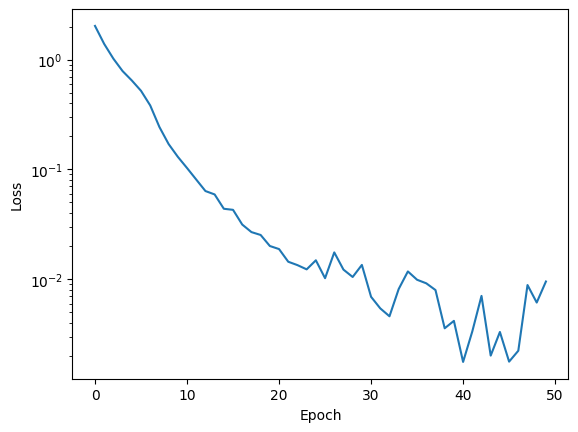

In [82]:
plt.plot(loss_per_epoch)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Generator

In [83]:
def pad_left(sequence, final_length, padding_token):
    return [padding_token] * (final_length - len(sequence)) + sequence

class Generator:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
    
    def generate(self, max_tokens_to_generate, prompt = None, temperature = 1.0, eos_token = None, padding_token = 0):
        self.model.eval()
        if prompt is None:
            start_tokens = [self.tokenizer.character_to_token(padding_token)]
        else:
            start_tokens = self.tokenizer.tokenize(prompt)
        
        input_tensor = torch.tensor(pad_left(sequence=start_tokens, final_length=self.model.max_sequence_length + 1, padding_token=padding_token), dtype=torch.long)
        num_dims = len(input_tensor.shape)
        if num_dims == 1:
            input_tensor = input_tensor[None, :]

        out = input_tensor
        for _ in range(max_tokens_to_generate):
            x = out[:, -self.model.max_sequence_length:]
            mask = torch.ones_like(x)
            mask[x == padding_token] = 0
            next_token_probabilites = self.model.next_token_probabilities(x=x, temperature = temperature, mask = mask)
            next_token = torch.multinomial(next_token_probabilites, num_samples=1)
            out = torch.cat([out, next_token], dim=1)
            if eos_token is not None and next_token == eos_token:
                break
        generated_tokens = out[0].tolist()
        return ''.join([self.tokenizer.token_to_character(token) for token in generated_tokens])    

In [87]:
max_tokens_to_generate = 50
generator = Generator(model, tokenizer)
generated_text = generator.generate(
    max_tokens_to_generate = max_tokens_to_generate,
    prompt = 'elephant',
    padding_token = tokenizer.character_to_token('<pad>')
)
print(generated_text.replace('<pad>', ''))

elephants have long trunks. monkeys like bananas. pandas e
